## Inferential Analysis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot

In [3]:
kandy_weather = pd.read_csv('../data/processed/kandy_weather_cleaned.csv', index_col=0, parse_dates=['time'])

In [4]:
kandy_weather.describe()

,weathercode,max_temperature,min_temperature,mean_temperature,apparent_temperature_mean,shortwave_radiation,rainfall,max_wind_speed,max_wind_gust,dominant_Wind_Direction,evapotranspiration,rain_today,rain_tomorrow,year,month,day
count,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000,4916.000000
mean,45.312856,27.127807,20.628519,23.504740,26.687714,18.110138,6.313120,11.783666,34.999919,170.186737,3.569583,0.800244,0.800448,2016.239219,6.413548,15.702400
std,22.213112,1.722015,1.391141,1.166783,1.671847,4.195949,13.306983,4.426484,10.370648,90.481482,0.870915,0.399857,0.399705,3.891004,3.452343,8.797572
min,0.000000,19.400000,14.200000,18.000000,19.800000,1.600000,0.000000,3.100000,14.800000,0.000000,0.500000,0.000000,0.000000,2010.000000,1.000000,1.000000
25%,51.000000,26.100000,20.100000,22.800000,25.700000,15.960000,0.300000,8.000000,26.300000,64.000000,3.070000,1.000000,1.000000,2013.000000,3.000000,8.000000
50%,53.000000,27.000000,20.900000,23.500000,26.600000,18.790000,2.200000,11.300000,32.800000,217.000000,3.660000,1.000000,1.000000,2016.000000,6.000000,16.000000
75%,61.000000,28.100000,21.500000,24.200000,27.700000,20.970000,6.100000,15.500000,42.800000,225.000000,4.150000,1.000000,1.000000,2020.000000,9.000000,23.000000
max,65.000000,33.400000,23.900000,27.900000,32.300000,28.120000,259.500000,24.300000,77.800000,359.000000,6.120000,1.000000,1.000000,2023.000000,12.000000,31.000000


In [5]:
kandy_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4916 entries, 2010-01-01 to 2023-06-17
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   weathercode                4916 non-null   int64  
 1   max_temperature            4916 non-null   float64
 2   min_temperature            4916 non-null   float64
 3   mean_temperature           4916 non-null   float64
 4   apparent_temperature_mean  4916 non-null   float64
 5   shortwave_radiation        4916 non-null   float64
 6   rainfall                   4916 non-null   float64
 7   max_wind_speed             4916 non-null   float64
 8   max_wind_gust              4916 non-null   float64
 9   dominant_Wind_Direction    4916 non-null   int64  
 10  evapotranspiration         4916 non-null   float64
 11  rain_today                 4916 non-null   int64  
 12  rain_tomorrow              4916 non-null   int64  
 13  year                       491

## Normality Test

In [6]:
variables =['max_wind_speed','max_wind_gust', 'evapotranspiration','shortwave_radiation']

shapiro_results = []
ks_results = []

for var in variables:
    data = kandy_weather[var].dropna()

    # Shapiro-Wilk test
    shapiro_stat, shapiro_p = stats.shapiro(data)
    shapiro_results.append({'Variable': var, 'Statistic': shapiro_stat, 'p-value': shapiro_p})

    # Kolmogorov–Smirnov test (against normal distribution with same mean & std)
    ks_stat, ks_p = stats.kstest(data, 'norm', args=(data.mean(), data.std()))
    ks_results.append({'Variable': var, 'Statistic': ks_stat, 'p-value': ks_p})


shapiro_df = pd.DataFrame(shapiro_results)
ks_df = pd.DataFrame(ks_results)
print("######## Shapiro-Wilk Test Results ########")
print(shapiro_df)
print("\n######## Kolmogorov–Smirnov Test Results ########")
print(ks_df)

######## Shapiro-Wilk Test Results ########
              Variable  Statistic       p-value
0       max_wind_speed   0.961201  2.286637e-34
1        max_wind_gust   0.946375  4.883543e-39
2   evapotranspiration   0.982755  4.981490e-24
3  shortwave_radiation   0.955288  2.240293e-36

######## Kolmogorov–Smirnov Test Results ########
              Variable  Statistic       p-value
0       max_wind_speed   0.084486  5.634671e-31
1        max_wind_gust   0.100350  1.504574e-43
2   evapotranspiration   0.053078  1.773873e-12
3  shortwave_radiation   0.074973  1.774744e-24


In [7]:

for col in variables:
  stat,p=stats.shapiro(kandy_weather[col])
  print(col)
  print('stat=%.4f, p=%.4f' % (stat,p))
  if p>0.05:
    print('normal distribution\n')
  else:
    print('not normal distribution\n')

max_wind_speed
stat=0.9612, p=0.0000
not normal distribution

max_wind_gust
stat=0.9464, p=0.0000
not normal distribution

evapotranspiration
stat=0.9828, p=0.0000
not normal distribution

shortwave_radiation
stat=0.9553, p=0.0000
not normal distribution



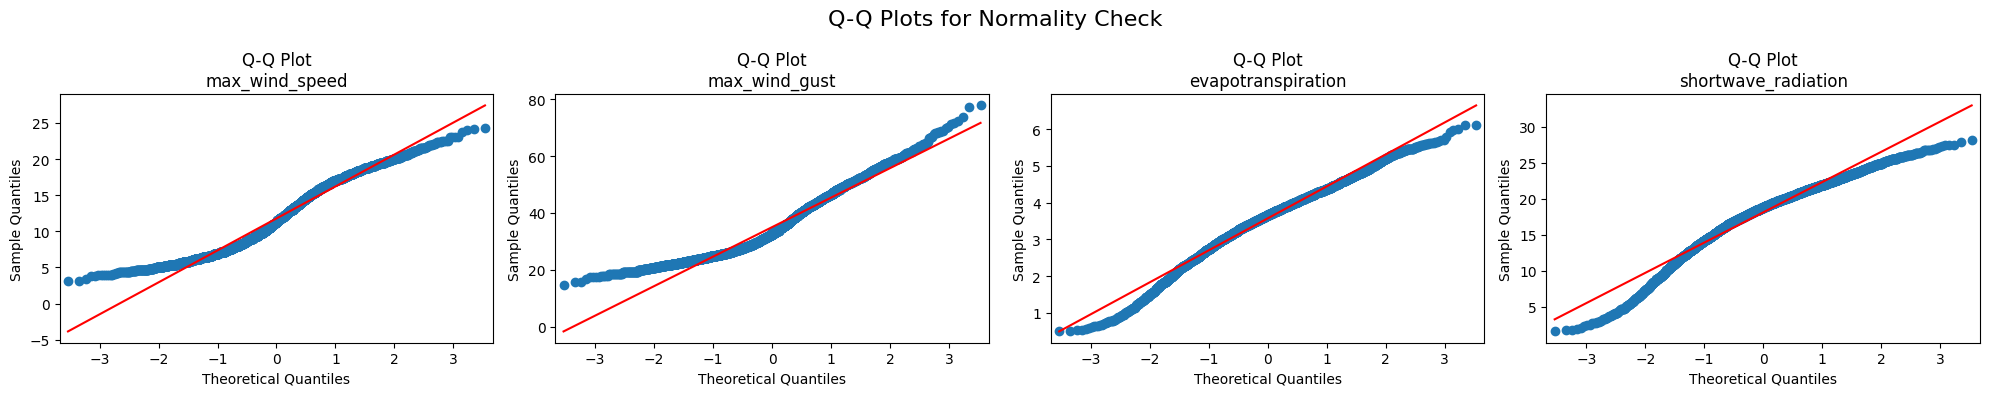

In [16]:
# Plot all Q-Q plots
fig_qq, axs_qq = plt.subplots(1, len(variables), figsize=(5 * len(variables), 4))
for i, var in enumerate(variables):
    data = kandy_weather[var].dropna()
    qqplot(data, line='s', ax=axs_qq[i])
    axs_qq[i].set_title(f'Q-Q Plot\n{var}')
fig_qq.suptitle("Q-Q Plots for Normality Check", fontsize=16)
plt.tight_layout()
plt.show()

In [15]:
for col in variables:
    total = len(kandy_weather[col])
    missing = kandy_weather[col].isna().sum()
    n = kandy_weather[col].count()

    print(f"Total rows of {col}:", total)
    print(f"Missing values of {col}:", missing)
    print(f"Sample size of {col}:", n)
    print("\n")


Total rows of max_wind_speed: 4916
Missing values of max_wind_speed: 0
Sample size of max_wind_speed: 4916


Total rows of max_wind_gust: 4916
Missing values of max_wind_gust: 0
Sample size of max_wind_gust: 4916


Total rows of evapotranspiration: 4916
Missing values of evapotranspiration: 0
Sample size of evapotranspiration: 4916


Total rows of shortwave_radiation: 4916
Missing values of shortwave_radiation: 0
Sample size of shortwave_radiation: 4916




## One Sample T test

Test whether the average mean temperature in Kandy equal to 25°C. Use a 5% level of significance.


In [ ]:
#one sample t test

mean_temp = kandy_weather['mean_temperature'].dropna()

# Perform one-sample t-test
t_stat, p_value = stats.ttest_1samp(mean_temp, popmean=25)


print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")




t-statistic: -89.8530
One-tailed p-value: 0.0000


Since the dataset contains 4916 observations (n > 30), according to the Central Limit Theorem, we can proceed with a parametric test (one-sample t test ) without checking the normality of the of the original data.

t - statistic <> 0
 P-Value : 0.0000
 Decision Rule: Reject H₀, if p-value < α
 Decision : Since, p-value (0.0000) < 0.05, Reject H₀
 Conclusion : We do have enough evidence to  say that the average mean temperature in Kandy equal to 25°C at 5% level of significance.